In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [155]:
df = pd.read_csv("ASIANPAINT_MAX_1.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,01-01-2015,751.099976,754.500000,747.000000,749.150024,714.733154,284935
1,02-01-2015,751.250000,781.450012,751.250000,775.049988,739.443176,2080850
2,05-01-2015,779.900024,787.900024,772.700012,775.000000,739.395447,1326999
3,06-01-2015,775.000000,783.000000,750.400024,756.500000,721.745239,1510720
4,07-01-2015,763.400024,778.349976,759.250000,771.700012,736.247070,1427667


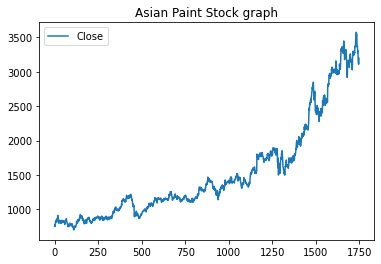

In [156]:
plt.plot(df['Close'],label = 'Close')
plt.title('Asian Paint Stock graph')
plt.legend()
plt.show()

In [157]:
# Lets perfrom some EDA on data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1749 entries, 0 to 1748
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1749 non-null   object 
 1   Open       1749 non-null   float64
 2   High       1749 non-null   float64
 3   Low        1749 non-null   float64
 4   Close      1749 non-null   float64
 5   Adj Close  1749 non-null   float64
 6   Volume     1749 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 95.8+ KB


In [158]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1749.000000,1749.000000,1749.000000,1749.000000,1749.000000,1.749000e+03
mean,1526.058005,1543.211635,1507.383821,1524.937192,1499.666032,1.382496e+06
std,714.045988,721.759447,705.606331,713.502130,723.019892,1.023258e+06
min,700.950012,706.000000,693.000000,698.549988,666.457642,7.026400e+04
25%,1003.099976,1017.049988,994.000000,1003.299988,972.370972,7.570530e+05
50%,1280.000000,1297.000000,1268.099976,1284.449951,1253.548828,1.103162e+06
75%,1787.599976,1806.300049,1766.849976,1789.550049,1766.066895,1.636939e+06
max,3580.000000,3590.000000,3534.000000,3576.300049,3576.300049,1.154592e+07


In [159]:
# lets check we any null value in our data or not
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [160]:
# So we have total 10 Null values in our data so we exchange the null values to the mean of the column
# So lets make copy of data 
df1 = df.copy()

In [161]:
df1.columns[1:]

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [162]:
for i in df1.columns[1:]:
    df1[i].fillna(df[i].mean(),inplace = True)

In [163]:
# So here we romove the all nun values with mean value
df1.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [164]:
df1.shape

(1749, 7)

In [165]:
# Making the DataFrame for Closing price
df1=df.reset_index()['Close']
df1

0        749.150024
1        775.049988
2        775.000000
3        756.500000
4        771.700012
           ...     
1744    3147.100098
1745    3116.949951
1746    3110.850098
1747    3152.250000
1748    3196.250000
Name: Close, Length: 1749, dtype: float64

In [166]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [167]:
print(df1)

[[0.01758319]
 [0.02658327]
 [0.0265659 ]
 ...
 [0.83825908]
 [0.85264528]
 [0.867935  ]]


In [168]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.70)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [169]:
training_size,test_size

(1224, 525)

In [170]:
train_data

array([[0.01758319],
       [0.02658327],
       [0.0265659 ],
       ...,
       [0.38382416],
       [0.38248631],
       [0.38537053]])

In [171]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [172]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [173]:
print(X_train.shape), print(y_train.shape)

(1123, 100)
(1123,)


(None, None)

In [174]:
print(X_test.shape), print(ytest.shape)

(424, 100)
(424,)


(None, None)

In [175]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [176]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [177]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [178]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 100, 50)           10400     
                                                                 
 lstm_22 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_23 (LSTM)              (None, 50)                20200     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [179]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
18/18 [==============================] - 11s 293ms/step - loss: 0.0060 - val_loss: 0.0437
Epoch 2/100
18/18 [==============================] - 4s 215ms/step - loss: 9.1500e-04 - val_loss: 0.0024
Epoch 3/100
18/18 [==============================] - 4s 224ms/step - loss: 4.1734e-04 - val_loss: 0.0045
Epoch 4/100
18/18 [==============================] - 4s 224ms/step - loss: 3.2286e-04 - val_loss: 0.0025
Epoch 5/100
18/18 [==============================] - 4s 230ms/step - loss: 3.1028e-04 - val_loss: 0.0029
Epoch 6/100
18/18 [==============================] - 4s 242ms/step - loss: 3.0000e-04 - val_loss: 0.0021
Epoch 7/100
18/18 [==============================] - 5s 254ms/step - loss: 3.1186e-04 - val_loss: 0.0016
Epoch 8/100
18/18 [==============================] - 5s 254ms/step - loss: 2.8607e-04 - val_loss: 0.0030
Epoch 9/100
18/18 [==============================] - 5s 260ms/step - loss: 2.7798e-04 - val_loss: 0.0023
Epoch 10/100
18/18 [==============================] - 5s 2

18/18 [==============================] - 6s 327ms/step - loss: 9.8254e-05 - val_loss: 4.3696e-04
Epoch 78/100
18/18 [==============================] - 6s 330ms/step - loss: 9.8745e-05 - val_loss: 4.5465e-04
Epoch 79/100
18/18 [==============================] - 6s 347ms/step - loss: 8.8122e-05 - val_loss: 5.0988e-04
Epoch 80/100
18/18 [==============================] - 6s 330ms/step - loss: 8.6391e-05 - val_loss: 4.2978e-04
Epoch 81/100
18/18 [==============================] - 6s 330ms/step - loss: 8.6912e-05 - val_loss: 4.4193e-04
Epoch 82/100
18/18 [==============================] - 6s 332ms/step - loss: 8.4400e-05 - val_loss: 5.3651e-04
Epoch 83/100
18/18 [==============================] - 6s 327ms/step - loss: 8.2961e-05 - val_loss: 7.6871e-04
Epoch 84/100
18/18 [==============================] - 6s 329ms/step - loss: 8.2527e-05 - val_loss: 8.0282e-04
Epoch 85/100
18/18 [==============================] - 6s 329ms/step - loss: 8.8195e-05 - val_loss: 4.5683e-04
Epoch 86/100
18/18 [===

In [180]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [181]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [182]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [183]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

1166.2911259895222

In [184]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

2522.8403079402037

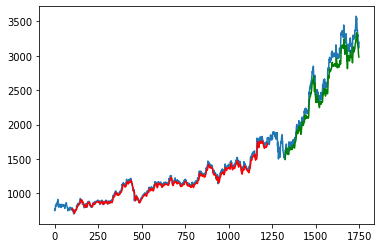

<Figure size 2520x1440 with 0 Axes>

In [194]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot,color="red")
plt.plot(testPredictPlot,color='green')
plt.figure(figsize=(35,20))
plt.show()

In [195]:
len(test_data)

525

In [200]:
x_input=test_data[425:].reshape(1,-1)
x_input.shape

(1, 100)

In [201]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [202]:
temp_input

[0.916705778500894,
 0.9200938420204242,
 0.9272869444654667,
 0.9257058311291614,
 0.9221614124743823,
 0.9186169938196033,
 0.9050473480295759,
 0.8941012966587859,
 0.9071844001952053,
 0.9100686148851759,
 0.9111631859678727,
 0.9556250722637029,
 0.9493874923420601,
 0.931682705644116,
 0.9119972219157916,
 0.8847536652002524,
 0.8615411545290556,
 0.8697941297689368,
 0.8882633855671734,
 0.8734949035589649,
 0.9008079419861751,
 0.9063851476710995,
 0.9060898291125082,
 0.9120667036274629,
 0.9121535770510406,
 0.9032230061344441,
 0.8836590941175556,
 0.8635913332711073,
 0.8586743315509916,
 0.8004343543301206,
 0.793623443867247,
 0.7712622757199205,
 0.7892450744005041,
 0.8326296110536336,
 0.8401529006170353,
 0.8345235197963913,
 0.8420641159357446,
 0.8356528743029014,
 0.8590391318212539,
 0.8550777377604927,
 0.8476934967563884,
 0.8501780426163287,
 0.8373729510625488,
 0.8218052165302344,
 0.8424463079179135,
 0.8583615361445388,
 0.8524541433412552,
 0.8797497900565

In [203]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.8129074]
101
1 day input [0.92009384 0.92728694 0.92570583 0.92216141 0.91861699 0.90504735
 0.8941013  0.9071844  0.91006861 0.91116319 0.95562507 0.94938749
 0.93168271 0.91199722 0.88475367 0.86154115 0.86979413 0.88826339
 0.8734949  0.90080794 0.90638515 0.90608983 0.9120667  0.91215358
 0.90322301 0.88365909 0.86359133 0.85867433 0.80043435 0.79362344
 0.77126228 0.78924507 0.83262961 0.8401529  0.83452352 0.84206412
 0.83565287 0.85903913 0.85507774 0.8476935  0.85017804 0.83737295
 0.82180522 0.84244631 0.85836154 0.85245414 0.87974979 0.87856835
 0.89052209 0.86421684 0.85429588 0.84986533 0.84946575 0.84988272
 0.8496568  0.84774559 0.86249676 0.83812003 0.81304839 0.81028583
 0.83744243 0.86183647 0.89813217 0.89698551 0.90311874 0.90466507
 0.90350102 0.88442356 0.88294672 0.89403181 0.89707238 0.89283289
 0.89870559 0.89439662 0.92768653 0.92742591 0.92681779 0.93281206
 0.94652067 0.95934324 0.98279906 0.97857696 1.         0.99207713
 0.98695159 0.98870645 0.95828336 

8 day output [[0.6279239]]
9 day input [0.91006861 0.91116319 0.95562507 0.94938749 0.93168271 0.91199722
 0.88475367 0.86154115 0.86979413 0.88826339 0.8734949  0.90080794
 0.90638515 0.90608983 0.9120667  0.91215358 0.90322301 0.88365909
 0.86359133 0.85867433 0.80043435 0.79362344 0.77126228 0.78924507
 0.83262961 0.8401529  0.83452352 0.84206412 0.83565287 0.85903913
 0.85507774 0.8476935  0.85017804 0.83737295 0.82180522 0.84244631
 0.85836154 0.85245414 0.87974979 0.87856835 0.89052209 0.86421684
 0.85429588 0.84986533 0.84946575 0.84988272 0.8496568  0.84774559
 0.86249676 0.83812003 0.81304839 0.81028583 0.83744243 0.86183647
 0.89813217 0.89698551 0.90311874 0.90466507 0.90350102 0.88442356
 0.88294672 0.89403181 0.89707238 0.89283289 0.89870559 0.89439662
 0.92768653 0.92742591 0.92681779 0.93281206 0.94652067 0.95934324
 0.98279906 0.97857696 1.         0.99207713 0.98695159 0.98870645
 0.95828336 0.92636604 0.93131782 0.92959774 0.89717656 0.9062114
 0.89524804 0.85365298 0

16 day output [[0.53425556]]
17 day input [0.86979413 0.88826339 0.8734949  0.90080794 0.90638515 0.90608983
 0.9120667  0.91215358 0.90322301 0.88365909 0.86359133 0.85867433
 0.80043435 0.79362344 0.77126228 0.78924507 0.83262961 0.8401529
 0.83452352 0.84206412 0.83565287 0.85903913 0.85507774 0.8476935
 0.85017804 0.83737295 0.82180522 0.84244631 0.85836154 0.85245414
 0.87974979 0.87856835 0.89052209 0.86421684 0.85429588 0.84986533
 0.84946575 0.84988272 0.8496568  0.84774559 0.86249676 0.83812003
 0.81304839 0.81028583 0.83744243 0.86183647 0.89813217 0.89698551
 0.90311874 0.90466507 0.90350102 0.88442356 0.88294672 0.89403181
 0.89707238 0.89283289 0.89870559 0.89439662 0.92768653 0.92742591
 0.92681779 0.93281206 0.94652067 0.95934324 0.98279906 0.97857696
 1.         0.99207713 0.98695159 0.98870645 0.95828336 0.92636604
 0.93131782 0.92959774 0.89717656 0.9062114  0.89524804 0.85365298
 0.85085572 0.84037874 0.83825908 0.85264528 0.867935   0.8129074
 0.79418015 0.7671451  

25 day output [[0.43426415]]
26 day input [0.88365909 0.86359133 0.85867433 0.80043435 0.79362344 0.77126228
 0.78924507 0.83262961 0.8401529  0.83452352 0.84206412 0.83565287
 0.85903913 0.85507774 0.8476935  0.85017804 0.83737295 0.82180522
 0.84244631 0.85836154 0.85245414 0.87974979 0.87856835 0.89052209
 0.86421684 0.85429588 0.84986533 0.84946575 0.84988272 0.8496568
 0.84774559 0.86249676 0.83812003 0.81304839 0.81028583 0.83744243
 0.86183647 0.89813217 0.89698551 0.90311874 0.90466507 0.90350102
 0.88442356 0.88294672 0.89403181 0.89707238 0.89283289 0.89870559
 0.89439662 0.92768653 0.92742591 0.92681779 0.93281206 0.94652067
 0.95934324 0.98279906 0.97857696 1.         0.99207713 0.98695159
 0.98870645 0.95828336 0.92636604 0.93131782 0.92959774 0.89717656
 0.9062114  0.89524804 0.85365298 0.85085572 0.84037874 0.83825908
 0.85264528 0.867935   0.8129074  0.79418015 0.7671451  0.73922074
 0.71235812 0.68746382 0.66503358 0.64522481 0.62792391 0.61282784
 0.59952211 0.5875487

In [204]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [208]:
len(df1)

1749

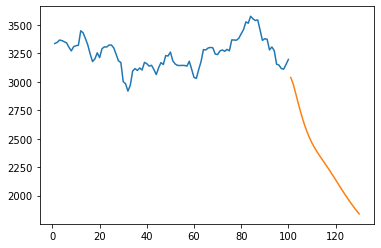

In [209]:
plt.plot(day_new,scaler.inverse_transform(df1[1649:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

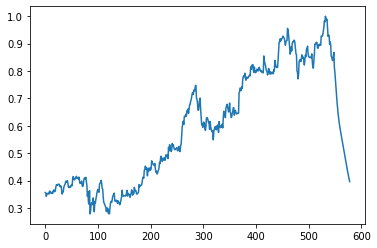

In [210]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [211]:
df3=scaler.inverse_transform(df3).tolist()

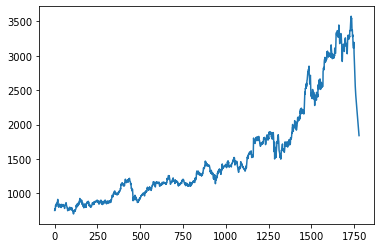

In [212]:
plt.plot(df3)